## Prepare input for Brink code for Barkley run PATH

* Shelf profile
* Stratification
* Input to all answers in code set up

Structure and snippets from Idalia's notebook ([https://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/analysis_mackenzie_canyon/raw/tip/notebooks/general_circulation/Brink_program.ipynb])

In [1]:
import cmocean as cmo
import gsw
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import scipy as sc, scipy.io
from scipy import interpolate

%matplotlib inline

In [2]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density in the water column using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be either arrays or scalars (if arrays, in coordinate order (...,Z, Y , X )) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...]) + beta*(S[...]))
    return rho

def calc_N2(RhoRef,rho,drC):
    '''INPUT:
    RhoRef: same as in calc_rho, reference density (scalar)
    rho: density (1D array size nz)
    drC: vertical spacing between cell centers (1D array size nz+1)
    OUTPUT:
    N2: buoyancy frequency squared (1D array size nz-2)'''
    
    g = 9.81 # m/s^2
    N2 = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(-drC[3:]-drC[2:-1])))            
    return(N2)

### 1. Shelf profile

In [3]:
bat_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/gridGlob.nc'
bathy = Dataset(bat_file)

depth = bathy['Depth'][:]
X = bathy['X'][:]
Y = bathy['Y'][:]
Z = bathy['Z'][:]


In [4]:
# Cross-shelf points for input (depth, distance pairs)

cs_points = 80
y_interp = np.linspace(np.round(np.max(Y),1),0, cs_points)

f_int = interpolate.interp1d(Y[:], -depth[:,180] , fill_value='extrapolate')
cs_interp = np.round(f_int(y_interp),1)


Text(0.5,0,'Cross-shelf distance / km')

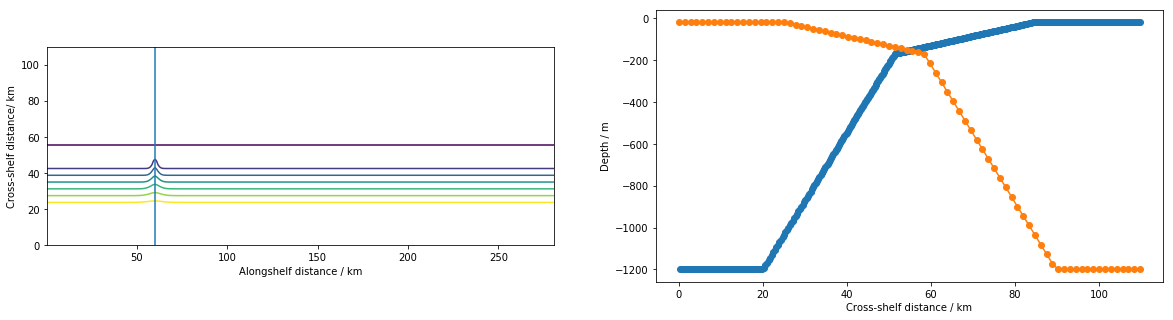

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].contour(X/1000,Y/1000,depth, 10)
ax[0].axvline(X[180]/1000)
ax[0].set_xlabel('Alongshelf distance / km')
ax[0].set_ylabel('Cross-shelf distance/ km')
ax[0].set_aspect(1)

ax[1].plot(Y/1000,-depth[:,180], 'o-')
ax[1].plot(y_interp[::-1]/1000,cs_interp, 'o-') # revert because 0 distance has to be at the coast

ax[1].set_ylabel('Depth / m')
ax[1].set_xlabel('Cross-shelf distance / km')

### 2. Stratification ($N^2$)

In [32]:
st_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc'
state = Dataset(st_file)

T = state['Temp'][0,:,50,180]
S = state['S'][0,:,50,180]
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds
Rho = calc_rho(RhoRef, T, S)
N2 = calc_N2(RhoRef,Rho,bathy['drC'][:])

In [49]:
# Vertical levels for input and interpolation. Model requires a surface value fro N^2.

nlevs = 100
z_interp = np.linspace(np.round(np.min(-bathy['Depth'][:,:]),1),0, nlevs)
z_increment = np.round(np.mean(np.abs(z_interp[1:]-z_interp[:-1])),1)

f_int = interpolate.interp1d(Z[1:-3], N2[0:-2], fill_value='extrapolate')
N2_interp = np.round(f_int(z_interp),12)


12.1


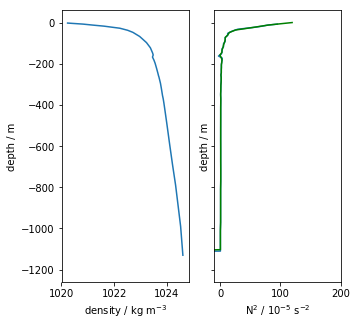

In [52]:
fig, ax = plt.subplots(1,2,figsize=(5,5), sharey=True)

ax[0].plot(Rho[0:-3], Z[:-3])
ax[0].set_xlabel('density / kg m$^{-3}$')
ax[0].set_ylabel('depth / m')

ax[1].plot(N2[0:-2]/1E-5, Z[1:-3])
ax[1].plot(N2_interp/1E-5, z_interp,'g')

ax[1].set_xlabel('N$^2$ / $10^{-5}$ s$^{-2}$')
ax[1].set_ylabel('depth / m')
ax[1].set_xlim(-10,200)
print(z_increment)

### 3. Alongshore velocity and bottom friction

In [9]:
start = 0
end = 18
Umean = np.mean(state['U'][start:end,:,:,:-1], axis=0)

Xu = bathy['Xp1'][:-1]
Yu = bathy['YC'][:]

In [10]:
max_vel0 = np.nanmax(abs(Umean))

try:
    inds = np.where(Umean == max_vel0)
    print(inds)
    ind_z = inds[0][0]
    ind_y = inds[1][0]
    ind_x = inds[2][0]
except IndexError:
    inds = np.where(Umean == -1*max_vel0)
    print(inds)
    ind_z = inds[0][0]
    ind_y = inds[1][0]
    ind_x = inds[2][0]

max_vel = Umean[ind_z, ind_y, ind_x]
print(max_vel)

(array([3]), array([282]), array([105]))
0.36410746


Text(0.5,1,'max U, x=47.0 km')

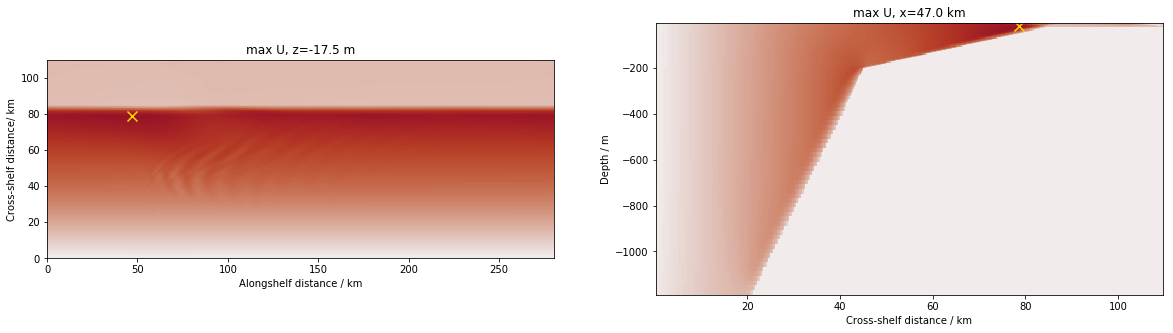

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.scatter(Xu[ind_x]/1000, Y[ind_y]/1000, s=100, c='gold', marker='x', zorder=2)
ax2.scatter(Y[ind_y]/1000, Z[ind_z], s=100, c='gold', marker='x', zorder=2)

ax1.pcolormesh(Xu/1000, Y/1000, Umean[ind_z, :, :], vmin=-0.5, vmax=0.5, cmap=cmo.cm.balance)
ax2.pcolormesh(Y/1000, Z, Umean[:, :, ind_x], vmin=-0.5, vmax=0.5, cmap=cmo.cm.balance)

ax1.set_xlabel('Alongshelf distance / km')
ax1.set_ylabel('Cross-shelf distance/ km')
ax1.set_aspect(1)
ax2.set_ylabel('Depth / m')
ax2.set_xlabel('Cross-shelf distance / km')
ax1.set_title('max U, z=%1.1f m' %Z[ind_z])
ax2.set_title('max U, x=%1.1f km' %(Xu[ind_x]/1000))


BE careful, result is very dependent on time slice.

In [12]:
# bottom friction ??? Not convinced about this
CDmin = 0.002
bfr = np.round(np.mean(Umean*100)*CDmin,4) #(cm/s)
bfr

0.014

### 4a. Wave length - initial guess in V

In [13]:
start = 0
end = 19
xini = 120
xfin = 400
yini = 100
yfin = 359

tslice = slice(start,end)
xslice = slice(xini,xfin, None)
yslice = slice(yini,yfin,None)


V_zavg = np.nanmean(state['V'][tslice,:,yslice,xslice], axis=1)
Yp1 = bathy['Yp1'][:]

Text(0.5,0,'A-S position of min V')

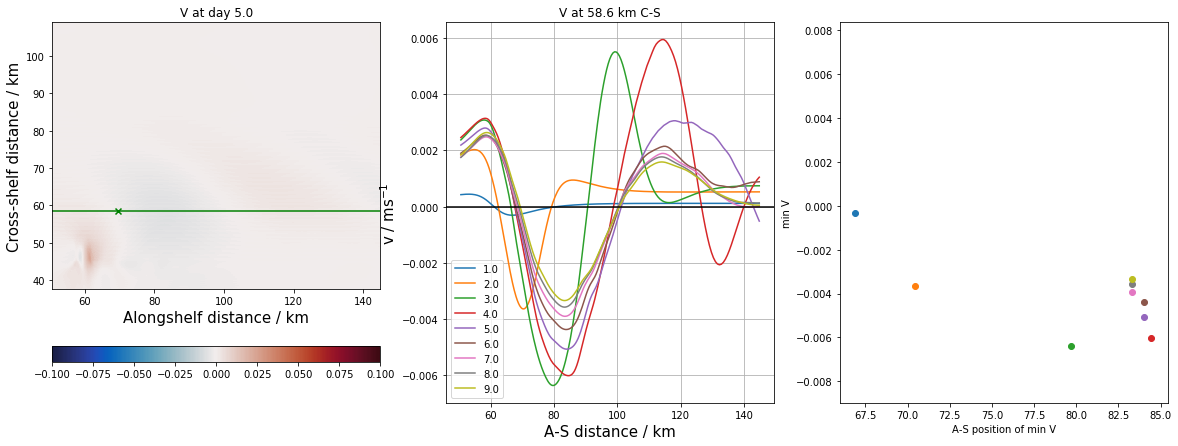

In [14]:
wave_x = 240
wave_y = 200
wave_t = 10

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

p = ax1.pcolormesh(X[xslice]/1000, Yp1[yslice]/1000, V_zavg[wave_t, :, :], cmap=cmo.cm.balance, vmin=-0.1, vmax=0.1)
ax1.axhline(Yp1[wave_y]/1000, c='green')
ax1.scatter(X[wave_x]/1000, Yp1[wave_y]/1000, marker='x', c='green')

fig.colorbar(p, ax=ax1, orientation='horizontal')
ax1.set_ylabel('Cross-shelf distance / km', fontsize=15)
ax1.set_xlabel('Alongshelf distance / km', fontsize=15)
ax1.set_title('V at day %1.1f' %(wave_t/2.))

for tt in range(2,19,2):
    wave_v = V_zavg[tt, wave_y-yini,:]
    ax2.plot(X[xslice]/1000, wave_v, label=tt/2.)
    
    ind_min = np.argmin(wave_v)
    min_v = np.nanmin(wave_v)
    ax3.scatter(X[ind_min+xini]/1000, min_v)

ax2.axhline(0,c='k')
ax2.set_xlabel('A-S distance / km', fontsize=15)
ax2.set_ylabel('v / ms$^{-1}$', fontsize=15)
ax2.legend(loc=0)
ax2.grid()
ax2.set_title('V at %1.1f km C-S' %(Yp1[wave_y]/1000.))

ax3.set_ylabel('min V')
ax3.set_xlabel('A-S position of min V')

In [15]:
k = (2.*np.pi)/50E3 # 2*25km comes from the green line trough to crest
print('wave number could be %e  1/m' %k)

wave number could be 1.256637e-04  1/m


### 4b. Wavelength in W 

In [16]:
start = 0
end = 19
xini = 120
xfin = 400
yini = 100
yfin = 359

tslice = slice(start,end)
xslice = slice(xini,xfin, None)
yslice = slice(yini,yfin,None)


W_zavg = np.nanmean(state['W'][tslice,:,yslice,xslice], axis=1)
YC = bathy['Y'][:]

wave number could be 5.715387e-04  1/m


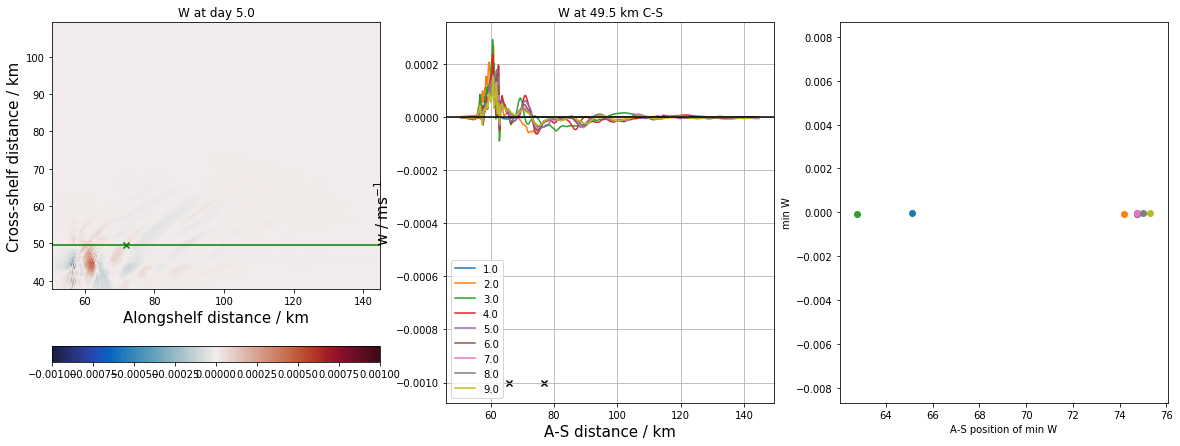

In [17]:
wave_x = 250
wave_y = 150
wave_t = 10

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

p = ax1.pcolormesh(X[xslice]/1000, YC[yslice]/1000, W_zavg[wave_t, :, :], cmap=cmo.cm.balance, vmin=-0.001, vmax=0.001)
ax1.axhline(YC[wave_y]/1000, c='green')
ax1.scatter(X[wave_x]/1000, YC[wave_y]/1000, marker='x', c='green')

fig.colorbar(p, ax=ax1, orientation='horizontal')
ax1.set_ylabel('Cross-shelf distance / km', fontsize=15)
ax1.set_xlabel('Alongshelf distance / km', fontsize=15)
ax1.set_title('W at day %1.1f' %(wave_t/2.))

for tt in range(2,19,2):
    wave_w = W_zavg[tt, wave_y-yini,:]
    ax2.plot(X[xslice]/1000, wave_w, label=tt/2.)
    
    ind_min = np.argmin(wave_w)
    min_w = np.nanmin(wave_w)
    ax3.scatter(X[ind_min+xini]/1000, min_w)
 
ax2.scatter(X[220]/1000,-0.001, marker='x', c='k')
ax2.scatter(X[268]/1000,-0.001, marker='x', c='k')

ax2.axhline(0,c='k')
ax2.set_xlabel('A-S distance / km', fontsize=15)
ax2.set_ylabel('w / ms$^{-1}$', fontsize=15)
ax2.legend(loc=0)
ax2.grid()
ax2.set_title('W at %1.1f km C-S' %(YC[wave_y]/1000.))

ax3.set_ylabel('min W')
ax3.set_xlabel('A-S position of min W')

k = (2.*np.pi)/((X[268]-X[220])) # comes from the distance between black x's
print('wave number could be %e  1/m' %k)

### 5. Wave frequency

In [18]:
start = 0
end = 19
xini = 120
xfin = 400
yini = 100
yfin = 359

tslice = slice(start,end)
xslice = slice(xini,xfin, None)
yslice = slice(yini,yfin,None)

W_zavg = np.nanmean(state['W'][tslice,:,yslice,xslice], axis=1)
YC = bathy['Y'][:]

4.629630e-06 1/s
ignore fft plot


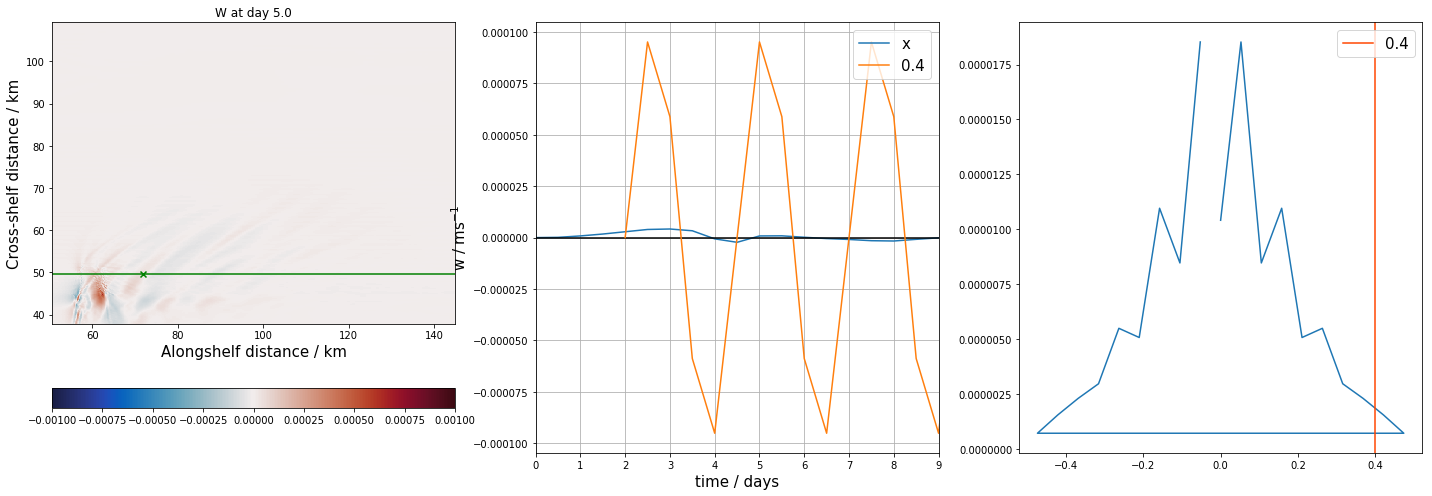

In [19]:
wave_x = 250
wave_y = 150
wave_t = 10

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

p = ax1.pcolormesh(X[xslice]/1000, YC[yslice]/1000, W_zavg[wave_t, :, :], cmap=cmo.cm.balance, vmin=-0.001, vmax=0.001)
ax1.axhline(YC[wave_y]/1000, c='green')
ax1.scatter(X[wave_x]/1000, YC[wave_y]/1000, marker='x', c='green')

fig.colorbar(p, ax=ax1, orientation='horizontal')
ax1.set_ylabel('Cross-shelf distance / km', fontsize=15)
ax1.set_xlabel('Alongshelf distance / km', fontsize=15)
ax1.set_title('W at day %1.1f' %(wave_t/2.))

wave_w = W_zavg[:, wave_y, wave_x]
ts = np.arange(wave_w.shape[0])/2

ax2.plot(ts, wave_w, label='x')
    
ax2.axhline(0,c='k')
ax2.set_xlim([ts[0], ts[-1]])
ax2.set_xlabel('time / days', fontsize=15)
ax2.set_ylabel('w / ms$^{-1}$', fontsize=15)
ax2.grid()

import numpy.fft as fft
spectrum = fft.fft(wave_w,axis=0)
freq = fft.fftfreq(len(spectrum))
ax3.plot(freq, abs(spectrum))

freq_s = [0.4]
cs = ['orangered', 'forestgreen', 'orange']
for freq_this, c in zip (freq_s, cs):
    ax2.plot(ts+2, 0.0001*np.sin(2 * np.pi * freq_this * ts), label=str(freq_this))
    ax3.axvline(freq_this, label=str(freq_this), c=c)
ax2.legend(loc=1, fontsize=15)
ax3.legend(loc=1, fontsize=15)

freq_per_day = freq_s[0]
freq_per_sec = freq_per_day/(3600*24)
print('%e 1/s' %freq_per_sec)
print('ignore fft plot')
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.06)

### Answers required for code initialization

In [20]:
wavenumber = k/100 #(1/m to 1/cm)
wavenumber_first = np.round(wavenumber*0.1,10)
numb_freq = 200
increment = np.round(wavenumber_first*0.1,10)

f = 1.0E-4 # 1/s Astoria run 01

In [53]:
print('How many total gridpoints do you want in the cross shelf direction? (nn)')
print(cs_points)  
print('\nHow many total gridpoints do you want in the vertical? (mm)')
print(nlevs)
print('\nFirst guess at frequency (rad/sec)? ')
print(freq_per_sec)
print('\nEnter 0 for a rigid lid, 1 for a free surface (del) ')
print(1)
print('\nEnter 0 for a closed x= 0 boundary, 1 for open (icbc) ')
print(0)
print('\nEnter 0 for a closed x =xmax boundary, 1 for an open (iobc)')
print(1)
print('\nEnter 1 for general frequency, wavenumber or 0 for long wave limit ')
print(1)
print('\nEnter the Coriolis parameter (f) (rad/sec) ')
print(f)
print('\nEnter the domain width (xmax) (km)')
width = y_interp[0]/1000
print(width)
print('\nEnter the nominal fractional accuracy for the solution (eps) ')
print(0.001)
print('\nEnter the number of frequencies to be computed (npts) ')
print(numb_freq)
print('***** tests ', 1)
print('\nEnter the first alongshore wavenumber to use (rlz) (rad/cm) ')
print(wavenumber_first)
print('\nEnter the wavenumber increment to use after rlz (drl) (rad/cm)')
print(increment)
print('\nHow many distance, depth pairs will you provide (ndep >=1)')
print(len(cs_interp)+1)  
print('\nArray of offshore distances for depth values (xdep in km) (dimension ndep)')
print(y_interp[::-1]/1000)
print('\nArray of depths corresponding to xdep (depr in m)') # positive!
print(-cs_interp)
print('\nNumber of distance, bottom friction pairs to read (nr) ')
print(2)
print('\nOffshore distances for bottom friction values (xr in km) ')
print('[0 '+str(width)+']')
print('\nArray of bottom friction values corresponding to xr (rr in cm/sec)')
print('[' + str(abs(bfr)) + ' ' + str(abs(bfr)) + '] (C_D_min * u_mean_cm)')
print('\nNumber of Nsquared values to read? (nnsq)')
print(len(N2_interp))
print('\nDepth increment for input of Nsquared values? (zr in m)')
print(z_increment)
print('\nExponential tail length for Nsquared extrapolation (alph in km')
print(2)
print('\nNsquared values starting at the surface (nsqr in rad^2/sec^2) (nnsq values)')
print(N2_interp[::-1])
print('\nInput peak value of mean alongshore flow (vzero: cm/sec)')
print(0, '(but max vel is '+str(np.round(max_vel*100,1))+')')
print('Input distance offshore to peak mean flow (km)')# 2.2
print('Input depth of peak mean flow (m)')#100
print('Downward exponential scale of mean flow? (m)')#1100
print('Upward exponential scale of mean flow? (m)')#100
print('Offshore exponential scale of mean flow? (km)')#40
print('Onshore exponential scale of mean flow? (km)')#100
print('Enter 1 for undisturbed Nsquared offshore, 0 for onshore 1')


How many total gridpoints do you want in the cross shelf direction? (nn)
80

How many total gridpoints do you want in the vertical? (mm)
100

First guess at frequency (rad/sec)? 
4.6296296296296296e-06

Enter 0 for a rigid lid, 1 for a free surface (del) 
1

Enter 0 for a closed x= 0 boundary, 1 for open (icbc) 
0

Enter 0 for a closed x =xmax boundary, 1 for an open (iobc)
1

Enter 1 for general frequency, wavenumber or 0 for long wave limit 
1

Enter the Coriolis parameter (f) (rad/sec) 
0.0001

Enter the domain width (xmax) (km)
109.7536

Enter the nominal fractional accuracy for the solution (eps) 
0.001

Enter the number of frequencies to be computed (npts) 
200
***** tests  1

Enter the first alongshore wavenumber to use (rlz) (rad/cm) 
5.715e-07

Enter the wavenumber increment to use after rlz (drl) (rad/cm)
5.72e-08

How many distance, depth pairs will you provide (ndep >=1)
81

Array of offshore distances for depth values (xdep in km) (dimension ndep)
[  0.           1.3892860

#### Frequency assuming standing waves

In [22]:
kv = (2*np.pi/(50E5))
U = 30 # cm/s

omega_v = U*kv
print(omega_v)

3.7699111843077517e-05


In [23]:
kw = k/100
U = 30 # cm/s

omega_w = U*kw
print(omega_w)

0.00017146160518819833
